In [ ]:
# ref : https://www.kaggle.com/maelstro/tweet-sentiment-analysis-binary-to-multi-class

### Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Listing the directories with datasets
import os

#Importing dependencies/packages

# Utility dependencies
import re
import pickle

# Graphic/math dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import time
import json
import itertools

from tqdm.auto import tqdm

In [ ]:
### nltk download
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Dataset

In [ ]:
# Constants - used in the notebook
ENCODING = "ISO-8859-1"
COLUMN_HEADERS = ["sentiment", "ids", "date", "flag", "user", "text"]

# Data exploration - importing the dataset and value lookup
data = pd.read_csv('/content/drive/MyDrive/Capstone/data/training.1600000.processed.noemoticon.csv',
                  encoding=ENCODING,
                  names=COLUMN_HEADERS)

In [ ]:
# Data lookup
print(data.head())

# Show the example tweet
data['text'][0]

   sentiment  ...                                               text
0          0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          0  ...  is upset that he can't update his Facebook by ...
2          0  ...  @Kenichan I dived many times for the ball. Man...
3          0  ...    my whole body feels itchy and like its on fire 
4          0  ...  @nationwideclass no, it's not behaving at all....

[5 rows x 6 columns]


"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [ ]:
data.shape

(1600000, 6)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   ids        1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


### Text 전처리

전처리 단계

1. 소문자 변환
2. URLs, Emojis, Usernames 전처리
3. 알파벳 아닌 문자 제거
4. 3번 이상 반복되는 문자 2개짜리 문자로 변환
5. 길이 1인 단어 제거
6. stop word 제거
7. 표제어 추출

In [ ]:
# Extract the 'text' column from the dataset
texts = data['text']

# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

stopword_nltk = stopwords.words('english')

def preprocess(textdata):
    processedText = []
    # wordcount={}
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in tqdm(textdata):
        tweet = tweet.lower()

        # Replace all URls with 'URL'
        # tweet = re.sub(urlPattern,' URL',tweet)
        tweet = re.sub(urlPattern,' URL', tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word not in stopword_nltk:
                if len(word)>1:
                    # Lemmatizing the word.
                    word = wordLemm.lemmatize(word)

                    # # 단어 나온 횟수 체크
                    # if word not in wordcount.keys():
                    #     wordcount[word] = 1
                    # else:
                    #     wordcount[word] += 1

                    tweetwords += (word+' ')
                    
        processedText.append(tweetwords)

    return processedText

In [ ]:
# Preprocessing the texts

start = time.time()
processed_text = preprocess(texts)
print('Text processing complete.')
print(f'It took {round(time.time() - start)} seconds to complete this task.')

  0%|          | 0/1600000 [00:00<?, ?it/s]

Text processing complete.
It took 140 seconds to complete this task.


In [ ]:
# wordcount_list = sorted(wordcount.items(), key=lambda x: x[1], reverse=True)[:50000]
# len(wordcount_list)

In [ ]:
# wordcount = dict(wordcount_list)
# wordcount

In [ ]:
# word2index = {k : i for i, k in enumerate(wordcount)}
# word2index

In [ ]:
# print(json.dumps(word2index, ensure_ascii=False, indent="\t"))

In [ ]:
# with open('/content/drive/MyDrive/Capstone/data/words.json', 'w') as make_file:
#     json.dump(word2index, make_file, ensure_ascii=False, indent="\t")

### Word Cloud

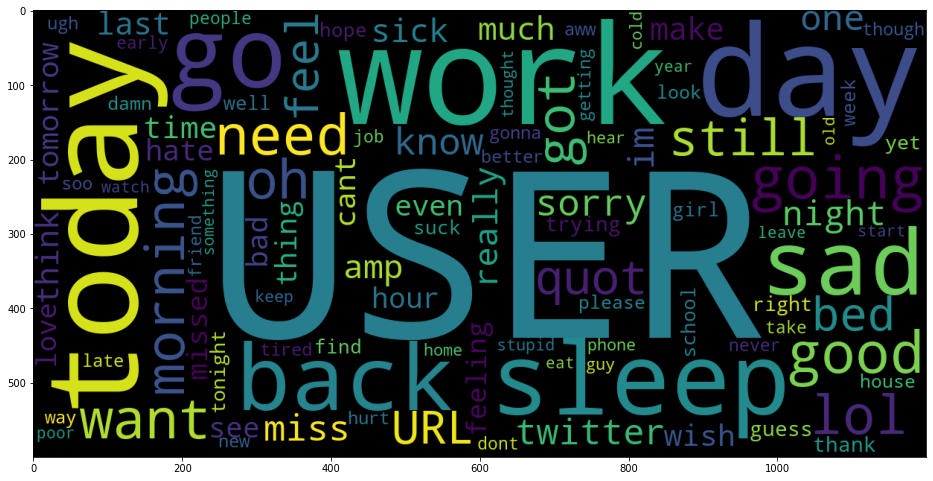

In [ ]:
# Select some random tweets
example_tweets = processed_text[1000:2000]

plt.figure(figsize=(16,16))
wc = WordCloud(max_words=100, width=1200, height=600,
              collocations=False).generate(" ".join(example_tweets))
plt.imshow(wc)

In [ ]:
data['preprocessed_text'] = processed_text

In [ ]:
# data['preprocessed_text_len'] = data.preprocessed_text.str.len()

In [ ]:
data.head()

,sentiment,ids,date,flag,user,text,preprocessed_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",USER URL aww bummer shoulda got david carr thi...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,USER dived many time ball managed save 50 rest...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",USER behaving mad see


In [ ]:
data.drop_duplicates(subset=['preprocessed_text'], inplace = True, ignore_index = True)
# data.reset_index(inplace = True, drop = True)

In [ ]:
data.head()

,sentiment,ids,date,flag,user,text,preprocessed_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",USER URL aww bummer shoulda got david carr thi...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,USER dived many time ball managed save 50 rest...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",USER behaving mad see


In [ ]:
data.shape

(1481469, 7)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481469 entries, 0 to 1481468
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   sentiment          1481469 non-null  int64 
 1   ids                1481469 non-null  int64 
 2   date               1481469 non-null  object
 3   flag               1481469 non-null  object
 4   user               1481469 non-null  object
 5   text               1481469 non-null  object
 6   preprocessed_text  1481469 non-null  object
dtypes: int64(2), object(5)
memory usage: 79.1+ MB


In [ ]:
data.to_feather('/content/drive/MyDrive/Capstone/data/sentiment140_text_preprocessed.ftr')